TODO:
2. lemmatize? (see if can use eliana's code)
3. remove stopwords
4. feature-generator (vector per group of texts bodies)
5. look for word embedding
6. understand deep LDA from reference (possibly different embedding)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import random
from pathlib import Path
from time import time
from datetime import datetime
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
from warnings import warn
from datetime import datetime
import itertools
from collections import Counter, OrderedDict
from bidi import algorithm as bidi
from hebrew_stopwords import hebrew_stopwords

In [3]:
mpl.rcParams.update({'font.size': 13})

# Load data

In [4]:
DATA = Path('Data')
meta = pd.read_csv(DATA/'meta.csv')
df = pd.read_csv(DATA/'data.csv')

C:\Users\idogr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Parser

In [5]:
WORDS_SEPS = ' | - |–|\t|\n\r|\n'
CHARS_TO_FILTER = '\.|,|"|\(|\)|;|:|\?|\t'

def tokenize(texts, seps=WORDS_SEPS, chars_to_filter=CHARS_TO_FILTER,
             stopwords=hebrew_stopwords, filter_fun=None, apply_fun=None):
    
    words = [re.split(seps,txt) for txt in texts]
    words = [re.sub(chars_to_filter, '', w.strip())
             for text_words in words for w in text_words]
    words = [w for w in words if w and w not in stopwords]
    
    if filter_fun:
        words = [w for w in words if filter_fun(w)]
    if apply_fun:
        words = [apply_fun(w) for w in words]
        
    return words

In [6]:
EXTRA_STOPWORDS = (
    'לך',
)

In [7]:
class Parser:
    def __init__(self, df, meta=None,
                 words_seps=WORDS_SEPS, chars_to_filter=CHARS_TO_FILTER,
                 filter_fun=lambda s: len(s)>1 or '0'<=s<='9', apply_fun=None,
                 stopwords=hebrew_stopwords+EXTRA_STOPWORDS):
        # data
        self.meta = meta
        self.df = df
        self.df.body.fillna('', inplace=True)
        self.df.header.fillna('', inplace=True)
        # tokenization conf
        self.words_seps = words_seps
        self.chars_to_filter = chars_to_filter
        self.filter_fun = filter_fun
        self.apply_fun = apply_fun # TODO use this for lemmatization
        self.stopwords = stopwords
        self.tokens = None
        # vocabulary
        
        
    def tokenize(self, by='ID'):
        self.tokens = self.df.groupby(by).apply(lambda d: tokenize(d.body.values, self.words_seps, self.chars_to_filter,
                                                                   self.stopwords, self.filter_fun, self.apply_fun))

    
    
    def full_protocol(self, ID=None):
        if ID is None:
            ID = random.choice(np.unique(self.df.ID))
        return '\n\n'.join(self.df[self.df.ID==ID].body.values)
    
    def show_tokens(self, **kwargs):
        show_freqs([tok for group in self.tokens for tok in group], **kwargs)

# EDA

In [8]:
def show_freqs(tokens, vocabulary=None, n=15, logscale=True, token_lab='Token', compact=False):
    if compact:
        _, axs = plt.subplots(1,3, figsize=(18,5))
    else:
        _, axs = plt.subplots(3,1, figsize=(12,12))
    
    if vocabulary:
        vocabulary = set(vocabulary)
        tokens = [token for token in  tokens if token in vocabulary]
    count = Counter(tokens)
    count = OrderedDict(sorted(count.items(), key=lambda kv: kv[1]))
    vals = list(count.values())
    keys = list(count.keys())
    bidi_keys = [bidi.get_display(token) for token in keys]
    
    # quantile plot
    ax = axs[0]
    ax.axhline(np.sum(vals)/len(vals), linestyle=':', color='blue', label='Average')
    ax.plot(list(range(101)), [vals[int(q/100*(len(vals)-1))] for q in range(101)], 'k.-')
    ax.set_xlabel('Quantile [%]')
    ax.set_ylabel('Number of occurences')
    ax.set_xlim((0,100))
    ax.set_title(f'Total: {len(tokens):d}, Unique: {len(keys):d}')
    if logscale:
        ax.set_yscale('log')
    ax.grid()
    ax.legend()
    
    # top tokens
    ax = axs[1]
    ax.bar(bidi_keys[-1:-n-1:-1], vals[-1:-n-1:-1])
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel(token_lab)
    ax.set_ylabel('Occurences')
    ax.set_title('Top')
    if logscale:
        ax.set_yscale('log')
    ax.grid()
    for label in ax.xaxis.get_ticklabels():
        label.set_ha('right')
    
    # tail tokens
    ax = axs[2]
    ax.bar(list(reversed(bidi_keys[:n])), list(reversed(vals[:n])))
    ax.tick_params(axis='x', rotation=45)
    for label in ax.xaxis.get_ticklabels():
        label.set_ha('right')
    ax.set_xlabel(token_lab)
    ax.set_ylabel('Occurences')
    ax.set_title('Tail')
    if logscale:
        ax.set_yscale('log')
    ax.grid()
    
    plt.tight_layout()
    
    return (list(reversed(keys)), list(reversed(vals)))

C:\Users\idogr\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


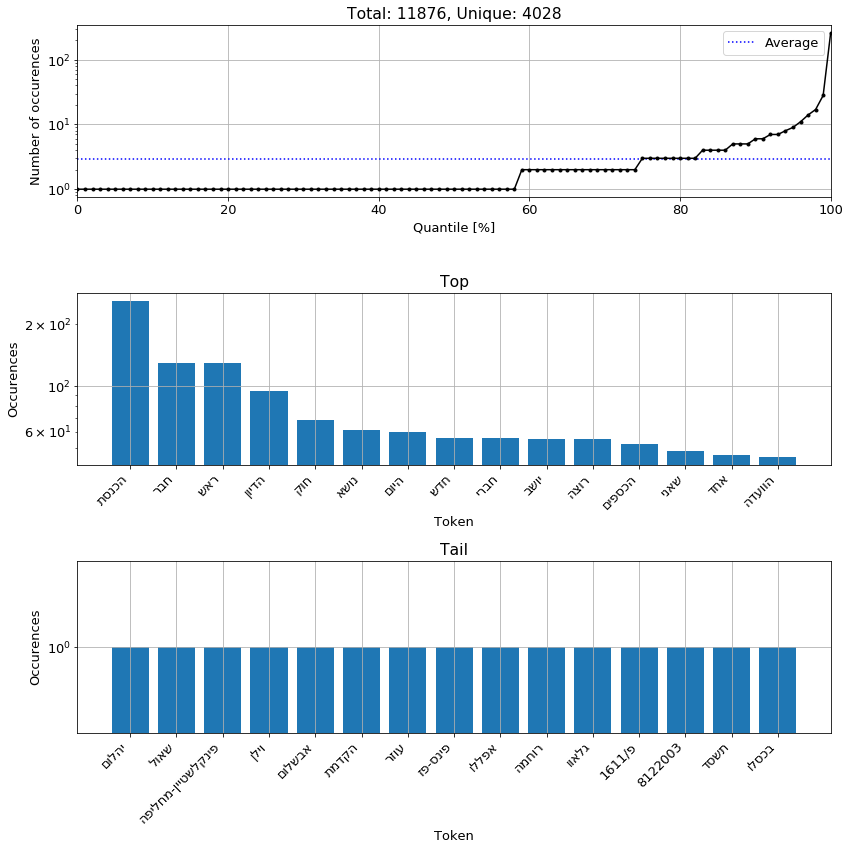

In [9]:
p = Parser(df, meta)
p.tokenize()
p.show_tokens()

In [10]:
OrderedDict(sorted(Counter(p.tokens[71333]).items(), key=lambda kv: kv[1], reverse=1))

OrderedDict([('הכנסת', 165),
             ('חבר', 103),
             ('הדיון', 55),
             ('חברי', 38),
             ('הוועדה', 33),
             ('היום', 32),
             ('המשפטי', 31),
             ('גורולובסקי', 29),
             ('הגדר', 28),
             ('מבקש', 27),
             ('הזאת', 26),
             ('ואני', 23),
             ('היועץ', 22),
             ('לממשלה', 22),
             ('אדוני', 22),
             ('הממשלה', 22),
             ('גדר', 21),
             ('הביטחון', 21),
             ('הבקשה', 21),
             ('כנסת', 21),
             ('דיון', 20),
             ('חזן', 20),
             ('חוק', 20),
             ('רוצה', 20),
             ('בדיון', 20),
             ('חושב', 20),
             ('נכון', 19),
             ('מחובת', 19),
             ('הצעת', 18),
             ('תודה', 18),
             ('רבה', 17),
             ('שאני', 17),
             ('העניין', 16),
             ('אחד', 16),
             ('בעניין', 16),
             ('הנחה', 16),
    

In [11]:
print(p.full_protocol())

p_tamars

2006-01-11Liraz









הכנסת השש-עשרה נוסח לא מתוקן

מושב שני

פרוטוקול מס' 86

מישיבת ועדת הכנסת

יום ראשון, י' בטבת התשס"ד (4 בינואר 2004), שעה: 12:00

סדר היום: א. סדרי הדיון בהצעת חוק התקציב לשנת 2004 ובהצעת חוק המדיניות

 הכלכלית לשנת הכספים 2004 (תיקוני חקיקה), התשס"ד-2003

 ובהצעת חוק גיל פרישה, התשס"ד-2003.

פניית יושב ראש ועדת הכספים בדבר טענה על חריגה מגדר נושא

 של הצעת חוק.

חברי הוועדה: רוני בר-און – היו"ר

 יולי-יואל אדלשטיין

 חיים אורון

 דליה איציק

 אריה אלדד

 אברהם בורג

 ענבל גבריאלי

 מיכאל גורלובסקי

 אברהם הירשזון

 רשף חן

 אחמד טיבי

 דוד טל

 דני יתום

 אליעזר (צ'יטה) כהן

 יצחק כהן

 מרינה סולודקין

 גדעון סער

 גילה פינקלשטיין

 מאיר פרוש

 עמיר פרץ

 אהוד רצאבי

 אברהם (בייגה) שוחט

 יובל שטייניץ

 אילן שלגי

 עמרי שרון

 מזכיר הכנסת, אריה האן

 סגן מזכיר הכנסת, דוד לב

 סגנית מזכיר הכנסת, רות קפלן

 מנהלת לשכת מזכיר הכנסת, גאולה רזיאל

לאה אחדות - ביטוח לאומי

אורי יוגב - סגן הממונה על התקציבים, משרד האוצר

יוסי גורדון - אגף התקציבים, משרד האו

הישיבה ננעלה בשעה: 13:45.


In [12]:
print(p.full_protocol())

knesset

2004-11-15Liraz



הכנסת 16

מושב 1

פרוטוקול מס' 250

מישיבת ועדת העבודה, הרווחה והבריאות

יום שני, כ"ו תשרי, תשס"ה, 11/10/04, שעה 11:00











סדר היום : פריט ועדה צווים, צו פעוטות בסיכון (הזכות למעון יום) (החלת הזכאות למעון יום),התשס"ד-2004 של ח''כ


In [13]:
print(p.full_protocol())

p_tamars

2006-01-11Liraz



הכנסת השש-עשרה נוסח לא מתוקן

 מושב שני

פרוטוקול מס' 74

מישיבת ועדת הכנסת

יום שני, י"ג בכסלו תשס"ד, 8.12.2003, שעה 10:00

א. קביעת מסגרת דיון להצעות להביע אי-אמון בממשלה.

ב. בקשת היועץ המשפטי לממשלה לנטילת חסינותם של חברי הכנסת מיכאל גורולובסקי ויחיאל

 חזן.

ג. בקשות חברי הכנסת להקדמת הדיון בהצעות חוק הבאות - בקריאה טרומית:

 1. הצעת חוק גדר הביטחון, התשס"ד-2003, של חבר הכנסת מתן וילנאי (פ/1611).

 2. הצעת חוק גדר הביטחון, התשס"ד-2003, של חבר הכנסת דני יתום וקבוצת חברי הכנסת

 (פ/1631).

 3. הצעת חוק שידורי פרסומות, תשדירי שירות ושידורי חסות בגלי צה"ל, התשס"ד-2003, של

 חבר הכנסת אורי אריאל (פ/1632).

נכחו: (בנושא בקשת היועץ המשפטי לממשלה לנטילת חסינותם של חברי הכנסת מיכאל

 גורולובסקי ויחיאל חזן)

 חברי הוועדה: רוני בר-און - היו"ר

 יולי-יואל אדלשטיין

 דליה איציק

 מיכאל איתן

 דניאל בנלולו

 ענבל גבריאלי

 מיכאל גורולובסקי

 זהבה גלאוו

רשף חן

 אחמד טיבי

 דני יתום

 יצחק כהן

 גדעון סער

 חבר הכנסת אהוד יתום - מחליף את חבר הכנסת עמרי שרון

 חבר הכ

הישיבה ננעלה בשעה 11:20.
